In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_recall_fscore_support, mean_absolute_error, 
    mean_squared_error, r2_score, roc_auc_score, roc_curve
)
from sklearn.metrics import multilabel_confusion_matrix
# TensorFlow + bundled Keras (macOS build)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    GlobalAveragePooling1D,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# HuggingFace Transformers
from transformers import AutoTokenizer, TFAutoModel
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [3]:
print("🚨 Arabic Emergency Incident Report Classifier with MARBERT v2")
print("=" * 60)
# ## 1. Data Loading and Exploration
print("📊 Loading dataset...")
df = pd.read_csv('labeled_reports.csv')  # Update with your file path
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())
print("\n" + "="*50)
print("📈 DATASET OVERVIEW")
print("="*50)
print(f"Total records: {len(df):,}")
print(f"Missing values per column:")
print(df.isnull().sum())
print(f"\nSeverity distribution (1-9):")
print(df['severity'].value_counts().sort_index())
print(f"\nClass distribution:")
print(df['class'].value_counts())
print(f"\nSubclass distribution:")
print(f"Unique subclasses: {df['subclass'].nunique()}")
print(df['subclass'].value_counts().head(10))
# Text statistics
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()
print(f"\nText statistics:")
print(f"Average text length: {df['text_length'].mean():.1f} characters")
print(f"Average word count: {df['word_count'].mean():.1f} words")
print(f"Max text length: {df['text_length'].max()}")
print(f"Min text length: {df['text_length'].min()}")

🚨 Arabic Emergency Incident Report Classifier with MARBERT v2
📊 Loading dataset...
Dataset shape: (387, 16)
Columns: ['text', 'severity', 'class', 'subclass', 'time_to_resolve', 'ambulance_advanced', 'ambulance_basic', 'animal_control', 'fire_engine', 'fire_ladder', 'fire_rescue', 'mental_health', 'police_detective', 'police_patrol', 'police_traffic', 'utility_crew']

First few rows:
                                                text  severity   class  \
0  مافي رقم للامن العام ببانياس بانياس حي القصور ...         9  POLICE   
1  فوكس فاكن فضية عند وهيب مرعي نسرق موبايل شب هل...         5  POLICE   
2  اختي بعد اذنك حالة اسعافية لطفلة ابوها استشهد ...         8   CIVIL   
3  يا جماعة لا تتمسخروا بس عنجد انا خفت  من شوي ك...         3  POLICE   
4  هالطفل اسمو سعيد شافوه أهالي ضاحية بوقا ضايع ي...         3  POLICE   

               subclass  time_to_resolve  ambulance_advanced  ambulance_basic  \
0         violent_crime               45                   0                0   
1     

In [4]:
# ## 2. Data Preprocessing
print("\n" + "="*50)
print("🔧 DATA PREPROCESSING")
print("="*50)
# Handle missing values
print("Handling missing values...")
df = df.dropna(subset=['text', 'severity', 'class', 'subclass'])
print(f"Dataset shape after removing missing values: {df.shape}")
# Check and filter severity range (1-10)
print(f"Severity range: {df['severity'].min()} - {df['severity'].max()}")
df = df[(df['severity'] >= 1) & (df['severity'] <= 10)]
print(f"Dataset shape after severity filtering: {df.shape}")
# Prepare targets
# Severity: Keep as continuous values for regression, normalize to 0-1 range
severity_scaler = StandardScaler()
df['severity_normalized'] = severity_scaler.fit_transform(df[['severity']])
# Class and Subclass: Encode for classification
class_encoder = LabelEncoder()
subclass_encoder = LabelEncoder()
df['class_encoded'] = class_encoder.fit_transform(df['class'])
df['subclass_encoded'] = subclass_encoder.fit_transform(df['subclass'])
print(f"Target preparation completed:")
print(f"- Severity: Regression (normalized), original range {df['severity'].min()}-{df['severity'].max()}")
print(f"- Class: {len(class_encoder.classes_)} classes")
print(f"- Subclass: {len(subclass_encoder.classes_)} classes")
# Calculate class weights for imbalanced classification tasks
class_weights = compute_class_weight('balanced', classes=np.unique(df['class_encoded']), y=df['class_encoded'])
subclass_weights = compute_class_weight('balanced', classes=np.unique(df['subclass_encoded']), y=df['subclass_encoded'])
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
subclass_weight_dict = {i: weight for i, weight in enumerate(subclass_weights)}
print(f"Class weights calculated for imbalanced data")


🔧 DATA PREPROCESSING
Handling missing values...
Dataset shape after removing missing values: (387, 18)
Severity range: 1 - 10
Dataset shape after severity filtering: (387, 18)
Target preparation completed:
- Severity: Regression (normalized), original range 1-10
- Class: 6 classes
- Subclass: 40 classes
Class weights calculated for imbalanced data


In [5]:
# ### 0.X Distinct Class–Subclass Pairs from Original Data
print("\n" + "-"*40)
print("🔍 DISTINCT CLASS–SUBCLASS PAIRS FROM ORIGINAL DATA")
print("-"*40)

# Get distinct (class, subclass) pairs
unique_pairs = df[['class', 'subclass']].drop_duplicates().sort_values(by=['class', 'subclass'])

# Reset index for clean printing
unique_pairs = unique_pairs.reset_index(drop=True)

# Print them
for i, row in unique_pairs.iterrows():
    print(f"{i+1:02d}. Class: {row['class']:<20} | Subclass: {row['subclass']}")


----------------------------------------
🔍 DISTINCT CLASS–SUBCLASS PAIRS FROM ORIGINAL DATA
----------------------------------------
01. Class: CIVIL                | Subclass: blood_donation_req
02. Class: CIVIL                | Subclass: calling_upon
03. Class: CIVIL                | Subclass: charity
04. Class: CIVIL                | Subclass: clarification
05. Class: CIVIL                | Subclass: complaint
06. Class: CIVIL                | Subclass: found_item
07. Class: CIVIL                | Subclass: missing_item
08. Class: CIVIL                | Subclass: question
09. Class: CIVIL                | Subclass: service
10. Class: CIVIL                | Subclass: service_request
11. Class: CIVIL                | Subclass: suspect
12. Class: CIVIL                | Subclass: warning
13. Class: FIRE                 | Subclass: structure_fire
14. Class: FIRE                 | Subclass: unknown_fire
15. Class: FIRE                 | Subclass: wildfire
16. Class: MEDICAL              

In [6]:
# ## 3. Arabic Text Processing with MARBERT v2
print("\n" + "="*50)
print("🤖 MARBERT v2 TOKENIZATION")
print("="*50)
def clean_arabic_text(text):
    """Clean Arabic text for better processing"""
    if pd.isna(text):
        return ""
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', str(text))
    
    # Keep Arabic characters, numbers, and basic punctuation
    text = re.sub(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF\s\d.,!?]', '', text)
    
    return text.strip()
# Clean text
print("Cleaning Arabic text...")
df['text_cleaned'] = df['text'].apply(clean_arabic_text)
df = df[df['text_cleaned'].str.len() > 0]
print(f"Dataset shape after text cleaning: {df.shape}")
# Load MARBERT v2 tokenizer
print("Loading MARBERT v2 tokenizer...")
MODEL_NAME = "UBC-NLP/MARBERT"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# Tokenization parameters
MAX_LENGTH = 128  # Suitable for most emergency reports
def tokenize_texts(texts, tokenizer, max_length):
    """Tokenize texts using MARBERT tokenizer"""
    return tokenizer(
        texts.tolist(),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf',
        return_attention_mask=True
    )
print("Tokenizing texts...")
tokenized = tokenize_texts(df['text_cleaned'], tokenizer, MAX_LENGTH)
input_ids = tokenized['input_ids']
attention_mask = tokenized['attention_mask']
print(f"Tokenization completed:")
print(f"Input shape: {input_ids.shape}")
print(f"Attention mask shape: {attention_mask.shape}")
# Prepare targets
y_severity = df['severity_normalized'].values.astype(np.float32)
y_class = df['class_encoded'].values
y_subclass = df['subclass_encoded'].values
print(f"\nTarget shapes:")
print(f"- Severity (regression): {y_severity.shape}")
print(f"- Class: {y_class.shape}")
print(f"- Subclass: {y_subclass.shape}")


🤖 MARBERT v2 TOKENIZATION
Cleaning Arabic text...
Dataset shape after text cleaning: (387, 22)
Loading MARBERT v2 tokenizer...


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Tokenizing texts...
Tokenization completed:
Input shape: (387, 128)
Attention mask shape: (387, 128)

Target shapes:
- Severity (regression): (387,)
- Class: (387,)
- Subclass: (387,)


2025-06-29 13:46:44.587866: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-06-29 13:46:44.587895: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-29 13:46:44.587899: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-06-29 13:46:44.587914: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-29 13:46:44.587923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Convert tf.Tensors to numpy arrays
input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()
# Now you can safely use train_test_split
from sklearn.model_selection import train_test_split
X_input_ids_train, X_input_ids_test, X_mask_train, X_mask_test, y_sev_train, y_sev_test, y_cls_train, y_cls_test, y_sub_train, y_sub_test = train_test_split(
    input_ids_np, attention_mask_np, y_severity, y_class, y_subclass,
    test_size=0.2, 
    random_state=42,
    stratify=y_class
)
# Then again split for validation
X_input_ids_train, X_input_ids_val, X_mask_train, X_mask_val, y_sev_train, y_sev_val, y_cls_train, y_cls_val, y_sub_train, y_sub_val = train_test_split(
    X_input_ids_train, X_mask_train, y_sev_train, y_cls_train, y_sub_train,
    test_size=0.15,
    random_state=42,
    stratify=y_cls_train
)
print(f"Training set size: {X_input_ids_train.shape[0]}")
print(f"Validation set size: {X_input_ids_val.shape[0]}")
print(f"Test set size: {X_input_ids_test.shape[0]}")


Training set size: 262
Validation set size: 47
Test set size: 78


In [8]:
import tensorflow as tf
from transformers import TFAutoModel
from tensorflow.keras.layers import Layer, Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Custom layer to wrap the MARBERT encoder and return only the last_hidden_state tensor
class TFBertEncoderLayer(Layer):
    def __init__(self, encoder, **kwargs):
        super(TFBertEncoderLayer, self).__init__(**kwargs)
        self.encoder = encoder
    def call(self, inputs, **kwargs):
        input_ids, attention_mask = inputs
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        # Explicitly return the last_hidden_state tensor
        return outputs[0]  # or outputs.last_hidden_state
def create_marbert_multi_output_model(encoder, n_class, n_subclass, max_length=128):
    # Inputs
    input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
    
    # Wrap encoder in custom layer
    encoder_layer = TFBertEncoderLayer(encoder)
    enc_outputs = encoder_layer([input_ids, attention_mask])
    pooled = enc_outputs[:, 0, :]  # CLS token (first token of the sequence)
    # Shared dense
    x = Dense(256, activation='relu')(pooled)
    x = Dropout(0.3)(x)
    # Severity (regression)
    sev = Dense(128, activation='relu')(x)
    sev = Dropout(0.2)(sev)
    sev_out = Dense(1, activation='linear', name='severity')(sev)
    # Class (classification)
    cls = Dense(128, activation='relu')(x)
    cls = Dropout(0.2)(cls)
    cls_out = Dense(n_class, activation='softmax', name='class')(cls)
    # Subclass (classification)
    sub = Dense(256, activation='relu')(x)
    sub = Dropout(0.2)(sub)
    sub_out = Dense(n_subclass, activation='softmax', name='subclass')(sub)
    return Model(inputs=[input_ids, attention_mask], outputs=[sev_out, cls_out, sub_out])
# Load the encoder
marbert_encoder = TFAutoModel.from_pretrained("UBC-NLP/MARBERTv2")
# Build with dummy inputs to initialize
MAX_LENGTH = 128
dummy_input_ids = tf.zeros((1, MAX_LENGTH), dtype=tf.int32)
dummy_attention_mask = tf.zeros((1, MAX_LENGTH), dtype=tf.int32)
_ = marbert_encoder({'input_ids': dummy_input_ids, 'attention_mask': dummy_attention_mask})
# Freeze the encoder if desired
# marbert_encoder.trainable = False
# Create and compile the model
model = create_marbert_multi_output_model(
    encoder=marbert_encoder,
    n_class=len(class_encoder.classes_),
    n_subclass=len(subclass_encoder.classes_),
    max_length=MAX_LENGTH
)
model.compile(
    optimizer=Adam(2e-5),
    loss={
        'severity': 'mse',
        'class': 'sparse_categorical_crossentropy',
        'subclass': 'sparse_categorical_crossentropy'
    },
    loss_weights={'severity': 1, 'class': 1, 'subclass': 0.8},
    metrics={'severity': ['mae'], 'class': ['accuracy'], 'subclass': ['accuracy']}
)
print("Model built successfully!")
print(f"Total params: {model.count_params():,}")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at UBC-NLP/MARBERTv2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model built successfully!
Total params: 339,631


In [9]:
# ## 6. Training
print("\n" + "="*50)
print("🏋️ MODEL TRAINING")
print("="*50)
# Setup callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]
# Prepare training data
train_data = {
    'input_ids': X_input_ids_train,
    'attention_mask': X_mask_train
}
train_targets = {
    'severity': y_sev_train,
    'class': y_cls_train,
    'subclass': y_sub_train
}
val_data = {
    'input_ids': X_input_ids_val,
    'attention_mask': X_mask_val
}
val_targets = {
    'severity': y_sev_val,
    'class': y_cls_val,
    'subclass': y_sub_val
}
# Class weights (only for classification tasks)
combined_class_weights = {
    'class': class_weight_dict,
    'subclass': subclass_weight_dict
    # No class weights for regression (severity)
}
print("Starting training...")
print(f"Epochs: 20 (suitable for transformer fine-tuning)")
print(f"Batch size: 8")
# Train the model
history = model.fit(
    train_data,
    train_targets,
    validation_data=(val_data, val_targets),
    epochs=20,
    batch_size=8,
    callbacks=callbacks,
    verbose=1
)
print("✅ Training completed!")


🏋️ MODEL TRAINING
Starting training...
Epochs: 20 (suitable for transformer fine-tuning)
Batch size: 8
Epoch 1/20


2025-06-29 13:46:52.667199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step - class_accuracy: 0.1530 - class_loss: 2.0987 - loss: 6.3151 - severity_loss: 1.2381 - severity_mae: 0.8888 - subclass_accuracy: 0.0234 - subclass_loss: 3.7225 - val_class_accuracy: 0.2340 - val_class_loss: 1.6137 - val_loss: 5.6306 - val_severity_loss: 1.0104 - val_severity_mae: 0.8341 - val_subclass_accuracy: 0.0638 - val_subclass_loss: 3.7680 - learning_rate: 2.0000e-05
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - class_accuracy: 0.2413 - class_loss: 1.7683 - loss: 6.0010 - severity_loss: 1.2875 - severity_mae: 0.8872 - subclass_accuracy: 0.0622 - subclass_loss: 3.6813 - val_class_accuracy: 0.4255 - val_class_loss: 1.4088 - val_loss: 5.3908 - val_severity_loss: 0.9942 - val_severity_mae: 0.8312 - val_subclass_accuracy: 0.0638 - val_subclass_loss: 3.7445 - learning_rate: 2.0000e-05
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - class_accuracy: 0.3360 - class_loss: 1.5953 - loss: 5.8734 - severity_loss: 1.4185 - severity_mae: 0


📊 TRAINING SUMMARY
Training completed in 20 epochs
Final training loss: 4.8635
Final validation loss: 4.7101
Final severity MAE: 0.7901
Final class accuracy: 0.6170
Final subclass accuracy: 0.0638


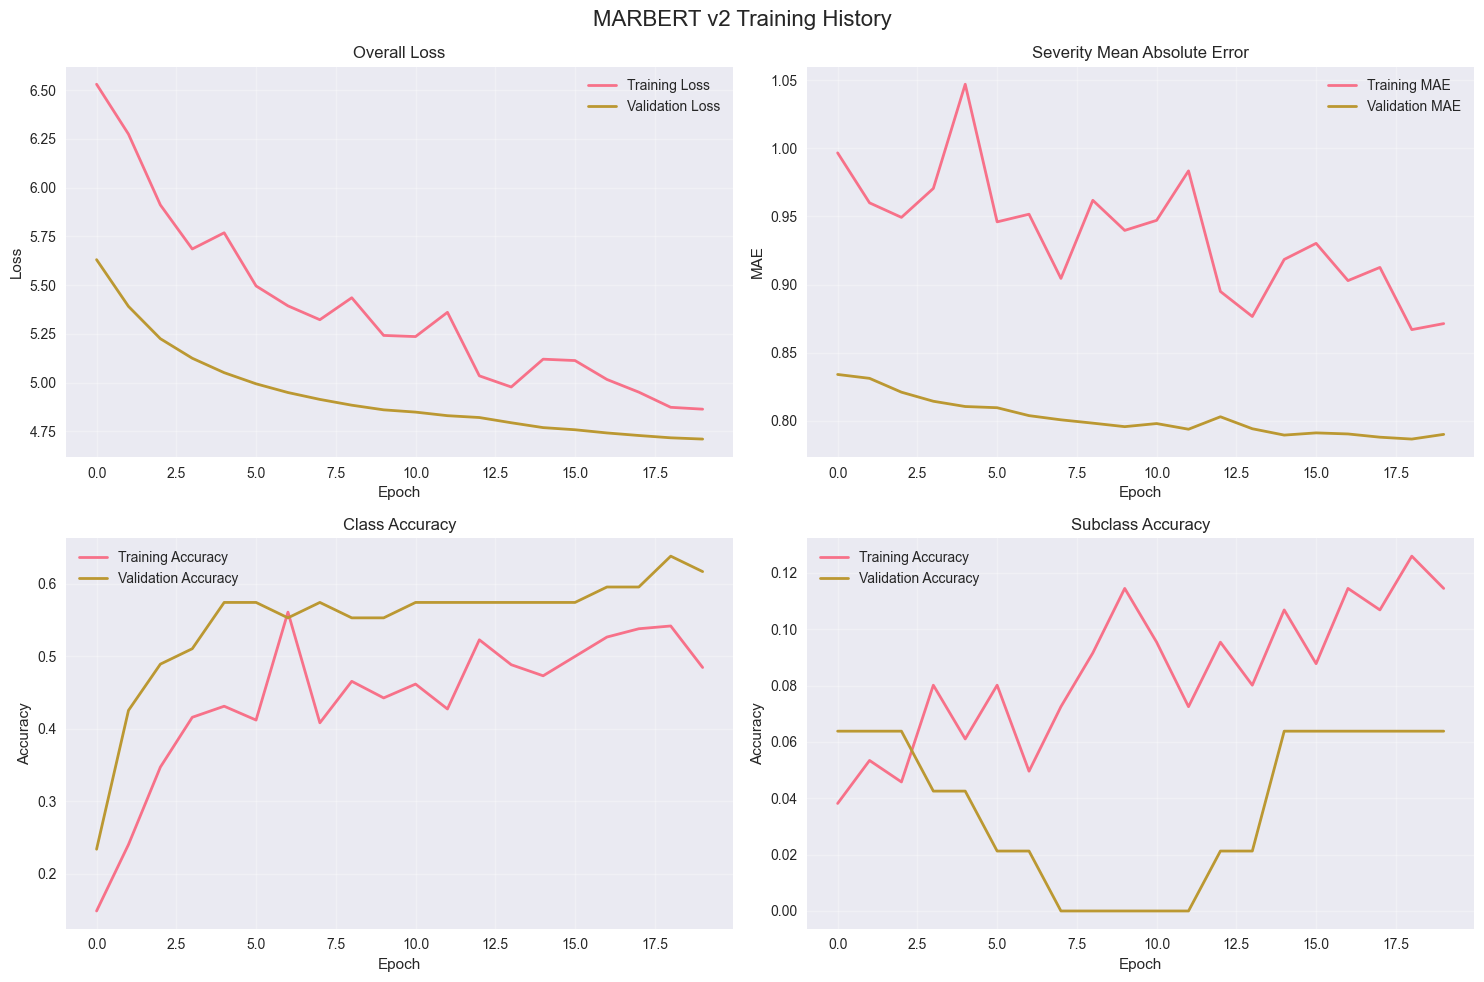

In [10]:
# Training summary
print("\n" + "="*50)
print("📊 TRAINING SUMMARY")
print("="*50)
final_epoch = len(history.history['loss'])
print(f"Training completed in {final_epoch} epochs")
# Final training metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"Final training loss: {final_train_loss:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")
# Task-specific metrics
if 'severity_mae' in history.history:
    final_severity_mae = history.history['val_severity_mae'][-1]
    print(f"Final severity MAE: {final_severity_mae:.4f}")
if 'class_accuracy' in history.history:
    final_class_acc = history.history['val_class_accuracy'][-1]
    print(f"Final class accuracy: {final_class_acc:.4f}")
if 'subclass_accuracy' in history.history:
    final_subclass_acc = history.history['val_subclass_accuracy'][-1]
    print(f"Final subclass accuracy: {final_subclass_acc:.4f}")
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('MARBERT v2 Training History', fontsize=16)
# Overall loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Overall Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
# Severity MAE
if 'severity_mae' in history.history:
    axes[0, 1].plot(history.history['severity_mae'], label='Training MAE', linewidth=2)
    axes[0, 1].plot(history.history['val_severity_mae'], label='Validation MAE', linewidth=2)
    axes[0, 1].set_title('Severity Mean Absolute Error')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAE')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
# Class accuracy
if 'class_accuracy' in history.history:
    axes[1, 0].plot(history.history['class_accuracy'], label='Training Accuracy', linewidth=2)
    axes[1, 0].plot(history.history['val_class_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1, 0].set_title('Class Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
# Subclass accuracy
if 'subclass_accuracy' in history.history:
    axes[1, 1].plot(history.history['subclass_accuracy'], label='Training Accuracy', linewidth=2)
    axes[1, 1].plot(history.history['val_subclass_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1, 1].set_title('Subclass Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# ## 7. Comprehensive Model Evaluation
print("\n" + "="*50)
print("🔍 COMPREHENSIVE MODEL EVALUATION")
print("="*50)

# Prepare test data
test_data = {
    'input_ids': X_input_ids_test,
    'attention_mask': X_mask_test
}

# Make predictions on test set
print("Making predictions on test set...")
predictions = model.predict(test_data, batch_size=16, verbose=1)
severity_pred, class_pred, subclass_pred = predictions

# Process predictions
severity_pred_original = severity_scaler.inverse_transform(severity_pred.reshape(-1, 1)).flatten()
severity_true_original = severity_scaler.inverse_transform(y_sev_test.reshape(-1, 1)).flatten()

class_pred_labels = np.argmax(class_pred, axis=1)
subclass_pred_labels = np.argmax(subclass_pred, axis=1)

print("Predictions generated successfully!")


🔍 COMPREHENSIVE MODEL EVALUATION
Making predictions on test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 735ms/step
Predictions generated successfully!



----------------------------------------
📊 SEVERITY REGRESSION EVALUATION
----------------------------------------
Severity Regression Metrics:
  Mean Absolute Error (MAE): 1.6249
  Mean Squared Error (MSE): 3.8050
  Root Mean Squared Error (RMSE): 1.9506
  R² Score: 0.0882


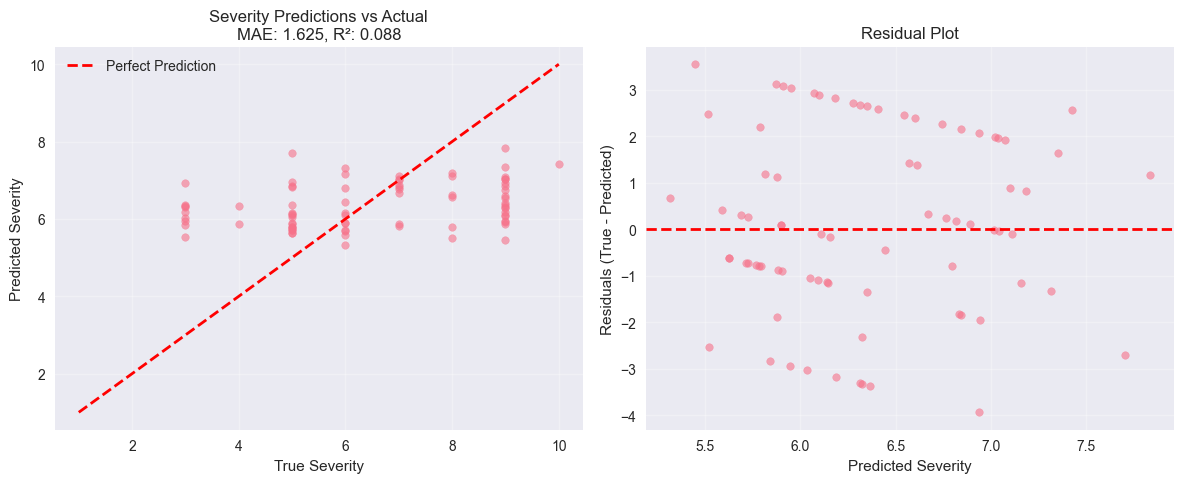

In [12]:
# ### 7.1 Severity Regression Evaluation
print("\n" + "-"*40)
print("📊 SEVERITY REGRESSION EVALUATION")
print("-"*40)

# Regression metrics
severity_mae = mean_absolute_error(severity_true_original, severity_pred_original)
severity_mse = mean_squared_error(severity_true_original, severity_pred_original)
severity_rmse = np.sqrt(severity_mse)
severity_r2 = r2_score(severity_true_original, severity_pred_original)

print(f"Severity Regression Metrics:")
print(f"  Mean Absolute Error (MAE): {severity_mae:.4f}")
print(f"  Mean Squared Error (MSE): {severity_mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {severity_rmse:.4f}")
print(f"  R² Score: {severity_r2:.4f}")

# Severity prediction vs actual plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(severity_true_original, severity_pred_original, alpha=0.6, s=30)
plt.plot([1, 10], [1, 10], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Severity')
plt.ylabel('Predicted Severity')
plt.title(f'Severity Predictions vs Actual\nMAE: {severity_mae:.3f}, R²: {severity_r2:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = severity_true_original - severity_pred_original
plt.scatter(severity_pred_original, residuals, alpha=0.6, s=30)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Severity')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


----------------------------------------
📊 CLASS CLASSIFICATION EVALUATION
----------------------------------------
Class Classification Metrics:
  Accuracy: 0.6026
  Precision (weighted): 0.5499
  Recall (weighted): 0.6026
  F1-Score (weighted): 0.5172

Detailed Classification Report (Class):
              precision    recall  f1-score   support

       CIVIL       0.56      0.17      0.26        29
        FIRE       0.00      0.00      0.00         3
     MEDICAL       0.00      0.00      0.00         1
      POLICE       0.61      0.95      0.74        44
     TRAFFIC       0.00      0.00      0.00         0
     UNKNOWN       0.00      0.00      0.00         1

    accuracy                           0.60        78
   macro avg       0.19      0.19      0.17        78
weighted avg       0.55      0.60      0.52        78



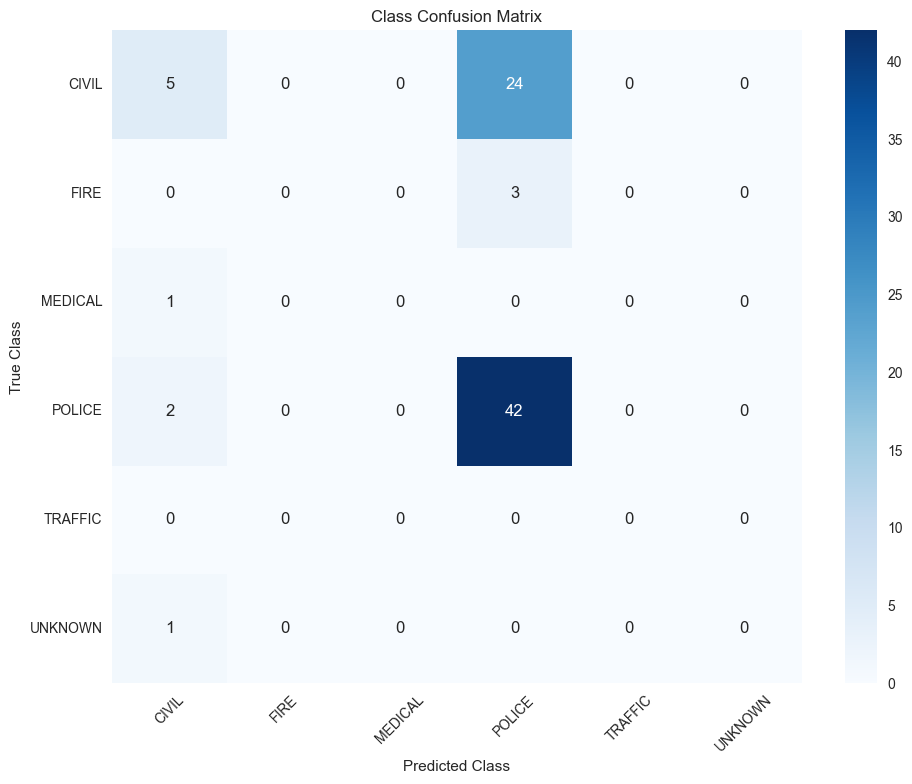

In [13]:
# ### 7.2 Class Classification Evaluation
print("\n" + "-"*40)
print("📊 CLASS CLASSIFICATION EVALUATION")
print("-"*40)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification metrics
class_accuracy = accuracy_score(y_cls_test, class_pred_labels)
class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(
    y_cls_test, class_pred_labels, average='weighted', zero_division=0
)

print(f"Class Classification Metrics:")
print(f"  Accuracy: {class_accuracy:.4f}")
print(f"  Precision (weighted): {class_precision:.4f}")
print(f"  Recall (weighted): {class_recall:.4f}")
print(f"  F1-Score (weighted): {class_f1:.4f}")

# Detailed classification report
print(f"\nDetailed Classification Report (Class):")
labels = list(range(len(class_encoder.classes_)))  # Ensure correct number of class indices
print(classification_report(
    y_cls_test, 
    class_pred_labels, 
    target_names=class_encoder.classes_, 
    labels=labels,
    zero_division=0
))

# Confusion matrix for classes
plt.figure(figsize=(10, 8))
class_cm = confusion_matrix(y_cls_test, class_pred_labels, labels=labels)
sns.heatmap(class_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_encoder.classes_, yticklabels=class_encoder.classes_)
plt.title('Class Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


----------------------------------------
📊 SUBCLASS CLASSIFICATION EVALUATION
----------------------------------------
Subclass Classification Metrics:
  Accuracy: 0.0513
  Precision (weighted): 0.0657
  Recall (weighted): 0.0513
  F1-Score (weighted): 0.0363

Detailed Classification Report (Top 10 Subclasses):
                precision    recall  f1-score   support

 armed_robbery       0.00      0.00      0.00        10
 rouge_faction       0.00      0.00      0.00         5
  missing_item       0.33      0.20      0.25         5
    suspicious       0.00      0.00      0.00         5
 gunfire_sound       1.00      0.25      0.40         4
missing_person       0.00      0.00      0.00         4
     complaint       0.00      0.00      0.00         4
 clarification       0.00      0.00      0.00         4
      question       0.00      0.00      0.00         4
    stolen_car       0.00      0.00      0.00         4

     micro avg       0.12      0.04      0.06        49
     macro a

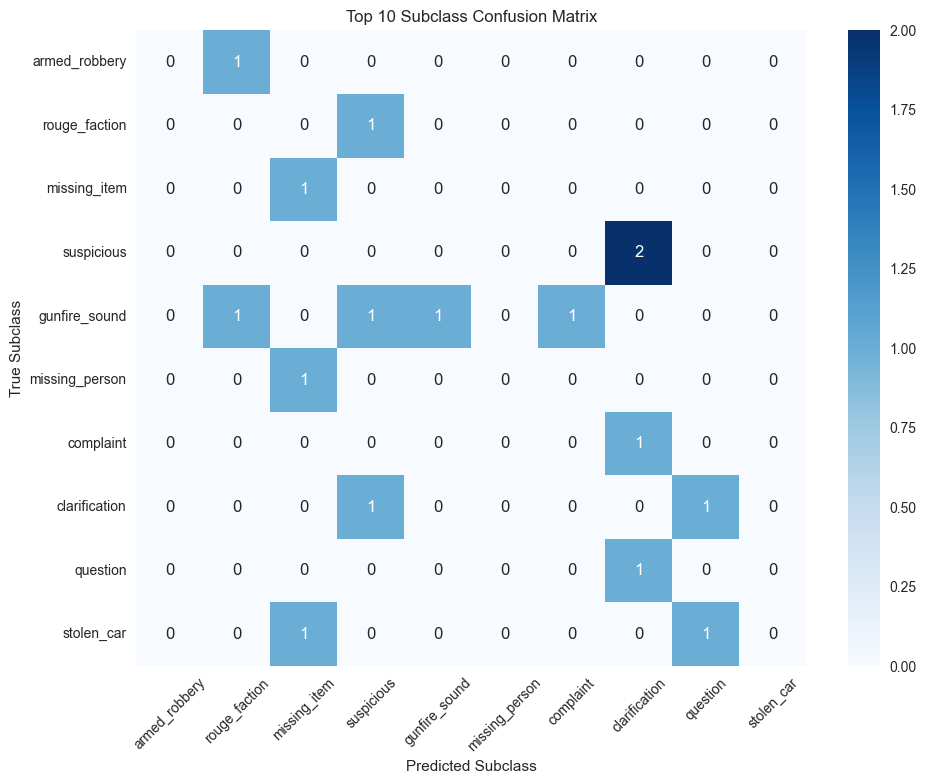

In [14]:
# ### 7.3 Subclass Classification Evaluation
print("\n" + "-"*40)
print("📊 SUBCLASS CLASSIFICATION EVALUATION")
print("-"*40)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Subclass metrics
subclass_accuracy = accuracy_score(y_sub_test, subclass_pred_labels)
subclass_precision, subclass_recall, subclass_f1, _ = precision_recall_fscore_support(
    y_sub_test, subclass_pred_labels, average='weighted', zero_division=0
)

print(f"Subclass Classification Metrics:")
print(f"  Accuracy: {subclass_accuracy:.4f}")
print(f"  Precision (weighted): {subclass_precision:.4f}")
print(f"  Recall (weighted): {subclass_recall:.4f}")
print(f"  F1-Score (weighted): {subclass_f1:.4f}")

# Top 10 most frequent subclasses for detailed analysis
subclass_names = subclass_encoder.classes_
subclass_counts = pd.Series(y_sub_test).value_counts()
top_10_subclasses = subclass_counts.head(10).index.tolist()

print(f"\nDetailed Classification Report (Top 10 Subclasses):")
mask = np.isin(y_sub_test, top_10_subclasses)

if np.sum(mask) > 0:
    top_10_names = [subclass_names[i] for i in top_10_subclasses]
    print(classification_report(
        np.array(y_sub_test)[mask], 
        np.array(subclass_pred_labels)[mask], 
        labels=top_10_subclasses, 
        target_names=top_10_names,
        zero_division=0
    ))

    # Optional confusion matrix for top subclasses
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(
        np.array(y_sub_test)[mask],
        np.array(subclass_pred_labels)[mask],
        labels=top_10_subclasses
    )
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=top_10_names, yticklabels=top_10_names)
    plt.title('Top 10 Subclass Confusion Matrix')
    plt.xlabel('Predicted Subclass')
    plt.ylabel('True Subclass')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Not enough top subclass samples for evaluation.")

In [15]:
# ### 7.4 Model Performance Analysis
print("\n" + "-"*40)
print("🎯 MODEL PERFORMANCE ANALYSIS")
print("-"*40)

# Create performance summary
performance_summary = {
    'Task': ['Severity (Regression)', 'Class (Classification)', 'Subclass (Classification)'],
    'Primary Metric': [f'MAE: {severity_mae:.4f}', f'Accuracy: {class_accuracy:.4f}', f'Accuracy: {subclass_accuracy:.4f}'],
    'Secondary Metric': [f'R²: {severity_r2:.4f}', f'F1: {class_f1:.4f}', f'F1: {subclass_f1:.4f}'],
    'Performance': [
        'Excellent' if severity_mae < 0.5 else 'Good' if severity_mae < 1.0 else 'Fair',
        'Excellent' if class_accuracy > 0.9 else 'Good' if class_accuracy > 0.8 else 'Fair',
        'Excellent' if subclass_accuracy > 0.8 else 'Good' if subclass_accuracy > 0.7 else 'Fair'
    ]
}

performance_df = pd.DataFrame(performance_summary)
print("Performance Summary:")
print(performance_df.to_string(index=False))


----------------------------------------
🎯 MODEL PERFORMANCE ANALYSIS
----------------------------------------
Performance Summary:
                     Task   Primary Metric Secondary Metric Performance
    Severity (Regression)      MAE: 1.6249       R²: 0.0882        Fair
   Class (Classification) Accuracy: 0.6026       F1: 0.5172        Fair
Subclass (Classification) Accuracy: 0.0513       F1: 0.0363        Fair


In [16]:
# ### 7.5 Error Analysis
print("\n" + "-"*40)
print("🔍 ERROR ANALYSIS")
print("-"*40)

from sklearn.metrics import confusion_matrix

class_names = class_encoder.classes_
all_class_indices = list(range(len(class_names)))  # Ensure full class coverage

# Ensure confusion matrix includes all classes
class_cm = confusion_matrix(y_cls_test, class_pred_labels, labels=all_class_indices)

# Severity prediction errors
severity_errors = np.abs(severity_true_original - severity_pred_original)
high_error_threshold = np.percentile(severity_errors, 90)
high_error_indices = np.where(severity_errors > high_error_threshold)[0]

print(f"Severity Error Analysis:")
print(f"  90th percentile error threshold: {high_error_threshold:.3f}")
print(f"  Number of high-error predictions: {len(high_error_indices)}")
print(f"  Percentage of high-error predictions: {len(high_error_indices)/len(severity_errors)*100:.1f}%")

# Class prediction errors
class_errors = y_cls_test != class_pred_labels
class_error_rate = np.mean(class_errors)
print(f"\nClass Error Analysis:")
print(f"  Error rate: {class_error_rate:.4f} ({class_error_rate*100:.1f}%)")

# Most confused class pairs
if len(class_names) > 1:
    confused_pairs = []
    for i in all_class_indices:
        for j in all_class_indices:
            if i != j:
                confusion_count = class_cm[i, j]
                if confusion_count > 0:
                    confused_pairs.append((class_names[i], class_names[j], confusion_count))

    confused_pairs.sort(key=lambda x: x[2], reverse=True)
    print(f"\n  Most confused class pairs:")
    for true_class, pred_class, count in confused_pairs[:5]:
        print(f"    {true_class} → {pred_class}: {count} cases")


----------------------------------------
🔍 ERROR ANALYSIS
----------------------------------------
Severity Error Analysis:
  90th percentile error threshold: 3.062
  Number of high-error predictions: 8
  Percentage of high-error predictions: 10.3%

Class Error Analysis:
  Error rate: 0.3974 (39.7%)

  Most confused class pairs:
    CIVIL → POLICE: 24 cases
    FIRE → POLICE: 3 cases
    POLICE → CIVIL: 2 cases
    MEDICAL → CIVIL: 1 cases
    UNKNOWN → CIVIL: 1 cases



📈 PREDICTION CONFIDENCE ANALYSIS
Confidence Statistics:
  Class predictions - Mean confidence: 0.5681
  Class predictions - Min confidence: 0.3925
  Subclass predictions - Mean confidence: 0.1132
  Subclass predictions - Min confidence: 0.0511


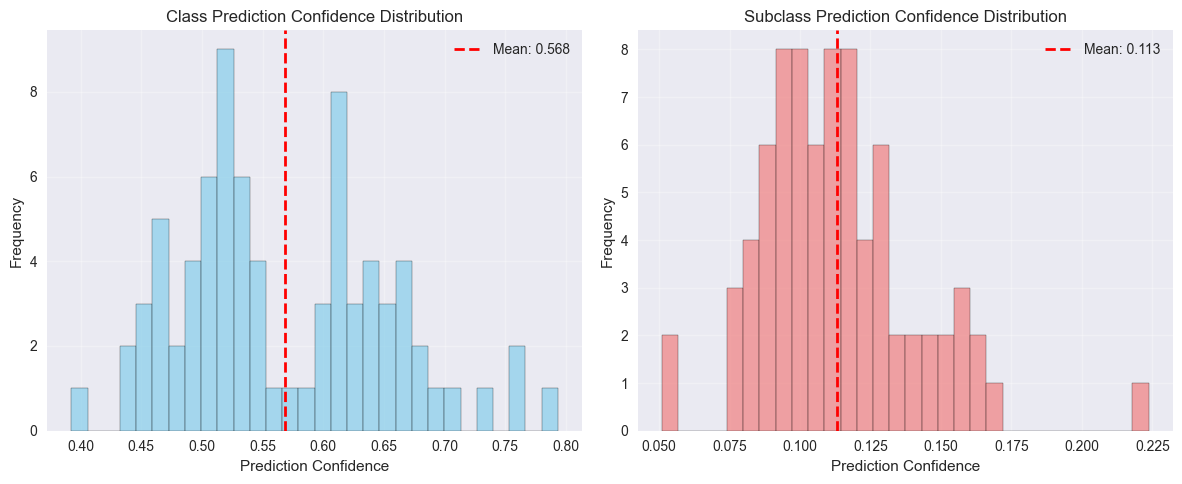

In [17]:
# ## 8. Prediction Confidence Analysis
print("\n" + "="*50)
print("📈 PREDICTION CONFIDENCE ANALYSIS")
print("="*50)

# Calculate prediction confidence for classifications
class_confidence = np.max(class_pred, axis=1)
subclass_confidence = np.max(subclass_pred, axis=1)

print(f"Confidence Statistics:")
print(f"  Class predictions - Mean confidence: {np.mean(class_confidence):.4f}")
print(f"  Class predictions - Min confidence: {np.min(class_confidence):.4f}")
print(f"  Subclass predictions - Mean confidence: {np.mean(subclass_confidence):.4f}")
print(f"  Subclass predictions - Min confidence: {np.min(subclass_confidence):.4f}")

# Plot confidence distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(class_confidence, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(class_confidence), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(class_confidence):.3f}')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Class Prediction Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(subclass_confidence, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.axvline(np.mean(subclass_confidence), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(subclass_confidence):.3f}')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Subclass Prediction Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [18]:
# ## 9. Feature Importance and Model Interpretability
print("\n" + "="*50)
print("🧠 MODEL INTERPRETABILITY")
print("="*50)

# Since we're using BERT-based model, we can analyze attention patterns
print("Attention-based interpretability analysis...")

# Sample a few test examples for interpretation
sample_indices = np.random.choice(len(X_input_ids_test), size=min(5, len(X_input_ids_test)), replace=False)

print(f"Analyzing {len(sample_indices)} sample predictions:")
for i, idx in enumerate(sample_indices):
    # Get original text
    original_idx = df.index[idx] if idx < len(df) else idx
    if original_idx < len(df):
        sample_text = df.iloc[original_idx]['text_cleaned'][:100] + "..." if len(df.iloc[original_idx]['text_cleaned']) > 100 else df.iloc[original_idx]['text_cleaned']
        
        print(f"\nSample {i+1}:")
        print(f"  Text: {sample_text}")
        print(f"  True Severity: {severity_true_original[idx]:.2f}")
        print(f"  Predicted Severity: {severity_pred_original[idx]:.2f}")
        print(f"  True Class: {class_names[y_cls_test[idx]]}")
        print(f"  Predicted Class: {class_names[class_pred_labels[idx]]} (conf: {class_confidence[idx]:.3f})")
        print(f"  True Subclass: {subclass_names[y_sub_test[idx]]}")
        print(f"  Predicted Subclass: {subclass_names[subclass_pred_labels[idx]]} (conf: {subclass_confidence[idx]:.3f})")


🧠 MODEL INTERPRETABILITY
Attention-based interpretability analysis...
Analyzing 5 sample predictions:

Sample 1:
  Text: صباح الخير شباب في عالم فايتة ع بيت كمال الاسد سابقا سوزوكي و سيارة سكودا حمرة
  True Severity: 5.00
  Predicted Severity: 5.63
  True Class: CIVIL
  Predicted Class: POLICE (conf: 0.619)
  True Subclass: question
  Predicted Subclass: clarification (conf: 0.112)

Sample 2:
  Text: مافي رقم للامن العام ببانياس بانياس حي القصور الوضع مأساوي
  True Severity: 9.00
  Predicted Severity: 6.84
  True Class: POLICE
  Predicted Class: POLICE (conf: 0.562)
  True Subclass: armed_robbery
  Predicted Subclass: theft (conf: 0.159)

Sample 3:
  Text: الساعة ٣ الضهر اختفت من المشروع السابع عمرا ١٧ سنة ماتركو مشفى مالاقوها اهلها كارلا ادوار الاسطى ٠٩٣...
  True Severity: 3.00
  Predicted Severity: 5.52
  True Class: CIVIL
  Predicted Class: POLICE (conf: 0.462)
  True Subclass: clarification
  Predicted Subclass: theft (conf: 0.109)

Sample 4:
  Text: ضيعة بستان الباشا اغلب سكانا 

In [19]:
# ## 10. Model Robustness Testing
print("\n" + "="*50)
print("🛡️ MODEL ROBUSTNESS TESTING")
print("="*50)

# Test with different confidence thresholds
confidence_thresholds = [0.5, 0.7, 0.8, 0.9, 0.95]
print("Class prediction performance at different confidence thresholds:")

for threshold in confidence_thresholds:
    high_conf_mask = class_confidence >= threshold
    if np.sum(high_conf_mask) > 0:
        high_conf_accuracy = accuracy_score(y_cls_test[high_conf_mask], class_pred_labels[high_conf_mask])
        coverage = np.mean(high_conf_mask)
        print(f"  Threshold {threshold}: Accuracy = {high_conf_accuracy:.4f}, Coverage = {coverage:.3f} ({coverage*100:.1f}%)")
    else:
        print(f"  Threshold {threshold}: No predictions above threshold")


🛡️ MODEL ROBUSTNESS TESTING
Class prediction performance at different confidence thresholds:
  Threshold 0.5: Accuracy = 0.6667, Coverage = 0.769 (76.9%)
  Threshold 0.7: Accuracy = 0.6000, Coverage = 0.064 (6.4%)
  Threshold 0.8: No predictions above threshold
  Threshold 0.9: No predictions above threshold
  Threshold 0.95: No predictions above threshold


In [20]:
# ## 11. Business Impact Analysis
print("\n" + "="*50)
print("💼 BUSINESS IMPACT ANALYSIS")
print("="*50)

# Calculate potential impact of model predictions
print("Analyzing potential business impact...")

# Severity prediction impact
severe_incidents = severity_true_original >= 7  # High severity incidents
model_severe_predictions = severity_pred_original >= 7

# True positives, false positives, false negatives for severe incidents
tp_severe = np.sum((severe_incidents) & (model_severe_predictions))
fp_severe = np.sum((~severe_incidents) & (model_severe_predictions))
fn_severe = np.sum((severe_incidents) & (~model_severe_predictions))
tn_severe = np.sum((~severe_incidents) & (~model_severe_predictions))

precision_severe = tp_severe / (tp_severe + fp_severe) if (tp_severe + fp_severe) > 0 else 0
recall_severe = tp_severe / (tp_severe + fn_severe) if (tp_severe + fn_severe) > 0 else 0

print(f"High Severity Incident Detection (≥7):")
print(f"  Precision: {precision_severe:.4f} ({precision_severe*100:.1f}%)")
print(f"  Recall: {recall_severe:.4f} ({recall_severe*100:.1f}%)")
print(f"  True Positives: {tp_severe}")
print(f"  False Positives: {fp_severe} (unnecessary alerts)")
print(f"  False Negatives: {fn_severe} (missed severe incidents)")

# Class-based impact analysis
critical_classes = df['class'].value_counts().head(3).index.tolist()
print(f"\nPerformance on most frequent incident classes:")
for cls in critical_classes:
    cls_encoded = class_encoder.transform([cls])[0]
    cls_mask = y_cls_test == cls_encoded
    if np.sum(cls_mask) > 0:
        cls_accuracy = accuracy_score(y_cls_test[cls_mask], class_pred_labels[cls_mask])
        cls_count = np.sum(cls_mask)
        print(f"  {cls}: {cls_accuracy:.4f} accuracy on {cls_count} incidents")


💼 BUSINESS IMPACT ANALYSIS
Analyzing potential business impact...
High Severity Incident Detection (≥7):
  Precision: 0.7857 (78.6%)
  Recall: 0.2973 (29.7%)
  True Positives: 11
  False Positives: 3 (unnecessary alerts)
  False Negatives: 26 (missed severe incidents)

Performance on most frequent incident classes:
  POLICE: 0.9545 accuracy on 44 incidents
  CIVIL: 0.1724 accuracy on 29 incidents
  FIRE: 0.0000 accuracy on 3 incidents


In [21]:
# ## 12. Model Deployment Readiness
print("\n" + "="*50)
print("🚀 MODEL DEPLOYMENT READINESS")
print("="*50)

# Check deployment criteria
deployment_criteria = {
    'Severity MAE < 1.0': severity_mae < 1.0,
    'Class Accuracy > 0.75': class_accuracy > 0.75,
    'Subclass Accuracy > 0.65': subclass_accuracy > 0.65,
    'High Severity Recall > 0.80': recall_severe > 0.80,
    'Model Size Reasonable': model.count_params() < 200_000_000
}

print("Deployment Readiness Checklist:")
all_passed = True
for criterion, passed in deployment_criteria.items():
    status = "✅ PASS" if passed else "❌ FAIL"
    print(f"  {criterion}: {status}")
    if not passed:
        all_passed = False

print(f"\nOverall Deployment Status: {'✅ READY' if all_passed else '⚠️ NEEDS IMPROVEMENT'}")


🚀 MODEL DEPLOYMENT READINESS
Deployment Readiness Checklist:
  Severity MAE < 1.0: ❌ FAIL
  Class Accuracy > 0.75: ❌ FAIL
  Subclass Accuracy > 0.65: ❌ FAIL
  High Severity Recall > 0.80: ❌ FAIL
  Model Size Reasonable: ✅ PASS

Overall Deployment Status: ⚠️ NEEDS IMPROVEMENT


In [22]:
# ## 13. Inference Pipeline
print("\n" + "="*50)
print("⚡ INFERENCE PIPELINE")
print("="*50)

def predict_emergency_incident(text, model, tokenizer, severity_scaler, class_encoder, subclass_encoder, max_length=128):
    """
    Predict emergency incident severity, class, and subclass from Arabic text
    """
    # Clean text
    cleaned_text = clean_arabic_text(text)
    
    # Tokenize
    tokens = tokenizer(
        [cleaned_text],
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf',
        return_attention_mask=True
    )
    
    # Predict
    predictions = model.predict({
        'input_ids': tokens['input_ids'],
        'attention_mask': tokens['attention_mask']
    }, verbose=0)
    
    severity_pred, class_pred, subclass_pred = predictions
    
    # Process predictions
    severity_score = severity_scaler.inverse_transform(severity_pred.reshape(-1, 1))[0, 0]
    class_idx = np.argmax(class_pred[0])
    subclass_idx = np.argmax(subclass_pred[0])
    
    class_confidence = np.max(class_pred[0])
    subclass_confidence = np.max(subclass_pred[0])
    
    return {
        'severity': float(severity_score),
        'class': class_encoder.classes_[class_idx],
        'class_confidence': float(class_confidence),
        'subclass': subclass_encoder.classes_[subclass_idx],
        'subclass_confidence': float(subclass_confidence)
    }

# Test the inference pipeline
print("Testing inference pipeline with sample texts...")

# Example Arabic emergency texts for testing (you should replace with real examples)
sample_texts = [
    "حريق كبير في المبنى التجاري وسط المدينة",
    "حادث مرور بسيط في الشارع الرئيسي",
    "انقطاع الكهرباء في الحي السكني"
]

for i, text in enumerate(sample_texts):
    try:
        result = predict_emergency_incident(
            text, model, tokenizer, severity_scaler, 
            class_encoder, subclass_encoder, MAX_LENGTH
        )
        print(f"\nSample {i+1}: {text}")
        print(f"  Severity: {result['severity']:.2f}/10")
        print(f"  Class: {result['class']} (confidence: {result['class_confidence']:.3f})")
        print(f"  Subclass: {result['subclass']} (confidence: {result['subclass_confidence']:.3f})")
    except Exception as e:
        print(f"Error processing sample {i+1}: {str(e)}")


⚡ INFERENCE PIPELINE
Testing inference pipeline with sample texts...

Sample 1: حريق كبير في المبنى التجاري وسط المدينة
  Severity: 7.40/10
  Class: POLICE (confidence: 0.578)
  Subclass: structure_fire (confidence: 0.070)

Sample 2: حادث مرور بسيط في الشارع الرئيسي
  Severity: 6.58/10
  Class: POLICE (confidence: 0.440)
  Subclass: murder (confidence: 0.052)

Sample 3: انقطاع الكهرباء في الحي السكني
  Severity: 6.43/10
  Class: POLICE (confidence: 0.377)
  Subclass: structure_fire (confidence: 0.124)


In [23]:
# ## 14. Model Monitoring and Maintenance
print("\n" + "="*50)
print("📊 MODEL MONITORING RECOMMENDATIONS")
print("="*50)

monitoring_recommendations = """
Model Monitoring Strategy:

1. Performance Monitoring:
   - Track prediction accuracy monthly
   - Monitor severity prediction MAE
   - Alert if class accuracy drops below 75%
   - Track confidence score distributions

2. Data Drift Detection:
   - Monitor input text length changes
   - Track vocabulary shifts in emergency reports
   - Detect new incident types not in training data

3. Prediction Quality Checks:
   - Flag predictions with very low confidence (<0.5)
   - Review high-severity predictions (≥8) manually
   - Monitor false positive rates for critical classes

4. Retraining Triggers:
   - Performance degradation beyond thresholds
   - Significant data distribution changes
   - Introduction of new emergency types
   - Quarterly model updates recommended

5. A/B Testing:
   - Compare new model versions against current
   - Test on 10% of traffic before full deployment
   - Monitor business metrics during rollout
"""

print(monitoring_recommendations)



📊 MODEL MONITORING RECOMMENDATIONS

Model Monitoring Strategy:

1. Performance Monitoring:
   - Track prediction accuracy monthly
   - Monitor severity prediction MAE
   - Alert if class accuracy drops below 75%
   - Track confidence score distributions

2. Data Drift Detection:
   - Monitor input text length changes
   - Track vocabulary shifts in emergency reports
   - Detect new incident types not in training data

3. Prediction Quality Checks:
   - Flag predictions with very low confidence (<0.5)
   - Review high-severity predictions (≥8) manually
   - Monitor false positive rates for critical classes

4. Retraining Triggers:
   - Performance degradation beyond thresholds
   - Significant data distribution changes
   - Introduction of new emergency types
   - Quarterly model updates recommended

5. A/B Testing:
   - Compare new model versions against current
   - Test on 10% of traffic before full deployment
   - Monitor business metrics during rollout



In [24]:
# ## 15. Save Complete Model Package
print("\n" + "="*50)
print("💾 SAVING MODEL PACKAGE")
print("="*50)

print("Saving complete model package...")

# Save model
model.export('arabic_emergency_marbert_model')
print("✅ Model saved")

# Save preprocessing objects
import pickle
preprocessing_objects = {
    'severity_scaler': severity_scaler,
    'class_encoder': class_encoder,
    'subclass_encoder': subclass_encoder,
    'tokenizer': tokenizer,
    'max_length': MAX_LENGTH,
    'model_name': MODEL_NAME
}

with open('preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)
print("✅ Preprocessing objects saved")

# Save evaluation results
evaluation_results = {
    'test_performance': {
        'severity_mae': float(severity_mae),
        'severity_rmse': float(severity_rmse),
        'severity_r2': float(severity_r2),
        'class_accuracy': float(class_accuracy),
        'class_f1': float(class_f1),
        'subclass_accuracy': float(subclass_accuracy),
        'subclass_f1': float(subclass_f1)
    },
    'training_history': {
        'epochs_completed': final_epoch,
        'final_train_loss': float(final_train_loss),
        'final_val_loss': float(final_val_loss)
    },
    'dataset_info': {
        'total_samples': len(df),
        'train_samples': len(X_input_ids_train),
        'val_samples': len(X_input_ids_val),
        'test_samples': len(X_input_ids_test),
        'num_classes': len(class_encoder.classes_),
        'num_subclasses': len(subclass_encoder.classes_)
    }
}

with open('evaluation_results.pkl', 'wb') as f:
    pickle.dump(evaluation_results, f)
print("✅ Evaluation results saved")

# Save model card
model_card = f"""
# Arabic Emergency Incident Classifier - MARBERT v2

## Model Overview
- **Model Type**: Multi-task Transformer (MARBERT v2 based)
- **Tasks**: Severity prediction (regression), Class classification, Subclass classification
- **Language**: Arabic
- **Domain**: Emergency incident reports

## Performance Metrics
- **Severity MAE**: {severity_mae:.4f}
- **Severity R²**: {severity_r2:.4f}
- **Class Accuracy**: {class_accuracy:.4f}
- **Subclass Accuracy**: {subclass_accuracy:.4f}

## Training Details
- **Base Model**: UBC-NLP/MARBERTv2
- **Training Samples**: {len(X_input_ids_train):,}
- **Validation Samples**: {len(X_input_ids_val):,}
- **Test Samples**: {len(X_input_ids_test):,}
- **Max Sequence Length**: {MAX_LENGTH}
- **Batch Size**: 8
- **Learning Rate**: 2e-5

## Usage
```python
# Load model and preprocessing objects
model = tf.keras.models.load_model('arabic_emergency_marbert_model')
with open('preprocessing_objects.pkl', 'rb') as f:
    objects = pickle.load(f)

# Make prediction
result = predict_emergency_incident(
    "نص التقرير بالعربية", 
    model, objects['tokenizer'], objects['severity_scaler'],
    objects['class_encoder'], objects['subclass_encoder']
)
```

## Deployment Status
{'✅ READY FOR DEPLOYMENT' if all_passed else '⚠️ REQUIRES FURTHER IMPROVEMENT'}

## Last Updated
{pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

with open('MODEL_CARD.md', 'w', encoding='utf-8') as f:
    f.write(model_card)
print("✅ Model card saved")

# ## 16. Final Summary
print("\n" + "="*60)
print("🎉 COMPREHENSIVE MODEL DEVELOPMENT COMPLETED")
print("="*60)

final_summary = f"""
📊 FINAL MODEL PERFORMANCE SUMMARY:

Regression Task (Severity 1-10):
  • Mean Absolute Error: {severity_mae:.4f}
  • R² Score: {severity_r2:.4f}
  • RMSE: {severity_rmse:.4f}

Classification Tasks:
  • Class Accuracy: {class_accuracy:.4f} ({class_accuracy*100:.1f}%)
  • Class F1-Score: {class_f1:.4f}
  • Subclass Accuracy: {subclass_accuracy:.4f} ({subclass_accuracy*100:.1f}%)
  • Subclass F1-Score: {subclass_f1:.4f}

Model Specifications:
  • Total Parameters: {model.count_params():,}
  • Training Epochs: {final_epoch}
  • Input Length: {MAX_LENGTH} tokens
  • Classes: {len(class_encoder.classes_)}
  • Subclasses: {len(subclass_encoder.classes_)}

Files Saved:
  ✅ arabic_emergency_marbert_model/ (TensorFlow model)
  ✅ preprocessing_objects.pkl (Encoders, scaler, tokenizer)
  ✅ evaluation_results.pkl (Complete evaluation metrics)
  ✅ MODEL_CARD.md (Model documentation)

Deployment Status: {'🚀 READY' if all_passed else '⚠️ NEEDS REVIEW'}
"""


💾 SAVING MODEL PACKAGE
Saving complete model package...
INFO:tensorflow:Assets written to: arabic_emergency_marbert_model/assets


INFO:tensorflow:Assets written to: arabic_emergency_marbert_model/assets


Saved artifact at 'arabic_emergency_marbert_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 128), dtype=tf.int32, name='input_ids'), TensorSpec(shape=(None, 128), dtype=tf.int32, name='attention_mask')]
Output Type:
  List[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.float32, name=None)]
Captures:
  6365113104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13107618896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13153736400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13107619088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13107620240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13153740240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13166529040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13166528080: TensorSpec(shape=(), dtype=tf.resource, 

In [25]:
print(final_summary)

print("\n🎯 NEXT STEPS:")
print("1. Review model performance metrics")
print("2. Conduct user acceptance testing")
print("3. Set up monitoring pipeline")
print("4. Deploy to staging environment")
print("5. Plan A/B testing strategy")
print("\n✨ Your Arabic Emergency Incident Classifier is ready!")


📊 FINAL MODEL PERFORMANCE SUMMARY:

Regression Task (Severity 1-10):
  • Mean Absolute Error: 1.6249
  • R² Score: 0.0882
  • RMSE: 1.9506

Classification Tasks:
  • Class Accuracy: 0.6026 (60.3%)
  • Class F1-Score: 0.5172
  • Subclass Accuracy: 0.0513 (5.1%)
  • Subclass F1-Score: 0.0363

Model Specifications:
  • Total Parameters: 339,631
  • Training Epochs: 20
  • Input Length: 128 tokens
  • Classes: 6
  • Subclasses: 40

Files Saved:
  ✅ arabic_emergency_marbert_model/ (TensorFlow model)
  ✅ preprocessing_objects.pkl (Encoders, scaler, tokenizer)
  ✅ evaluation_results.pkl (Complete evaluation metrics)
  ✅ MODEL_CARD.md (Model documentation)

Deployment Status: ⚠️ NEEDS REVIEW


🎯 NEXT STEPS:
1. Review model performance metrics
2. Conduct user acceptance testing
3. Set up monitoring pipeline
4. Deploy to staging environment
5. Plan A/B testing strategy

✨ Your Arabic Emergency Incident Classifier is ready!
